In [ ]:
eta = 0.50
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 12
n_center = 10
l = 5

num_layers = 30
width = 512

n_max_mirror_iterations=15       # num mirror steps
n_max_iterations=4000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100



In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=2b828093a926909be255df05d2797be0e7441cddeb3410abc785a54789823aee
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


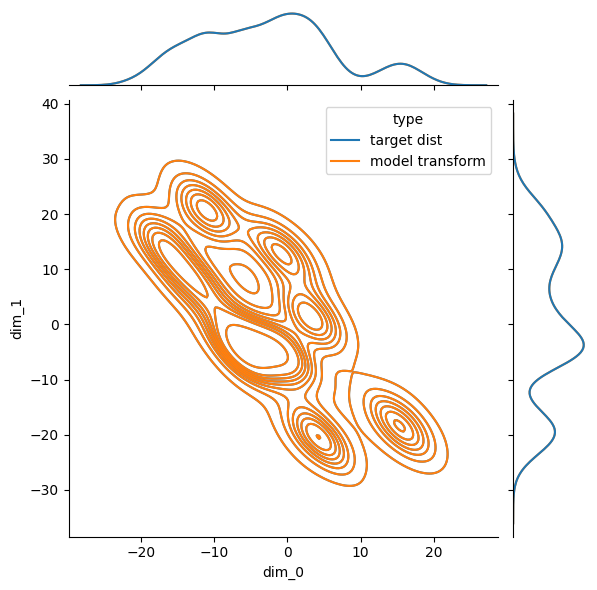

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])

trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]

Loss: 38.049156188964844


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


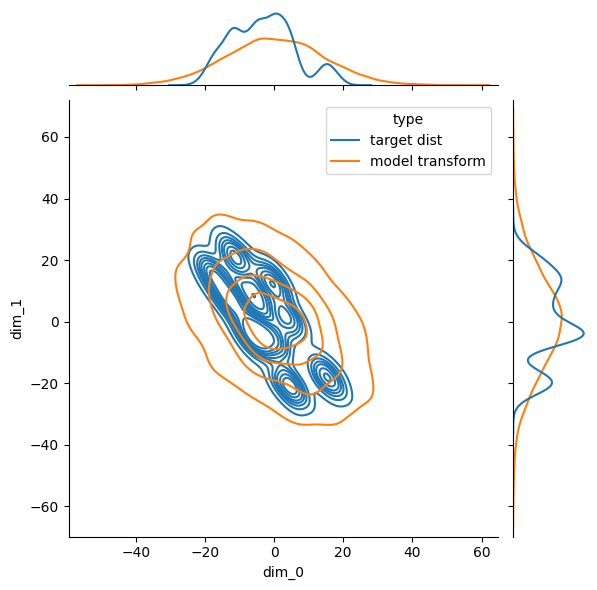

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

 25%|██▌       | 1000/4000 [13:55<46:23,  1.08it/s]

trail: 0 m step: 0 Loss: 30.0532169342041  L_n: 9.007265090942383  kld: 10.52297592163086 KLD1: 8.994460105895996 KLD2: 18.13786506652832


 50%|█████     | 2000/4000 [27:50<30:55,  1.08it/s]

trail: 0 m step: 0 Loss: 27.89470100402832  L_n: 7.514753341674805  kld: 10.189973831176758 KLD1: 7.425887107849121 KLD2: 20.423444747924805


 75%|███████▌  | 3000/4000 [41:45<15:28,  1.08it/s]

trail: 0 m step: 0 Loss: 27.189085006713867  L_n: 7.083757400512695  kld: 10.052663803100586 KLD1: 7.037738800048828 KLD2: 19.274036407470703


100%|██████████| 4000/4000 [55:40<00:00,  1.20it/s]

trail: 0 m step: 0 Loss: 26.805973052978516  L_n: 6.831733703613281  kld: 9.987119674682617 KLD1: 6.873537540435791 KLD2: 19.480077743530273



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


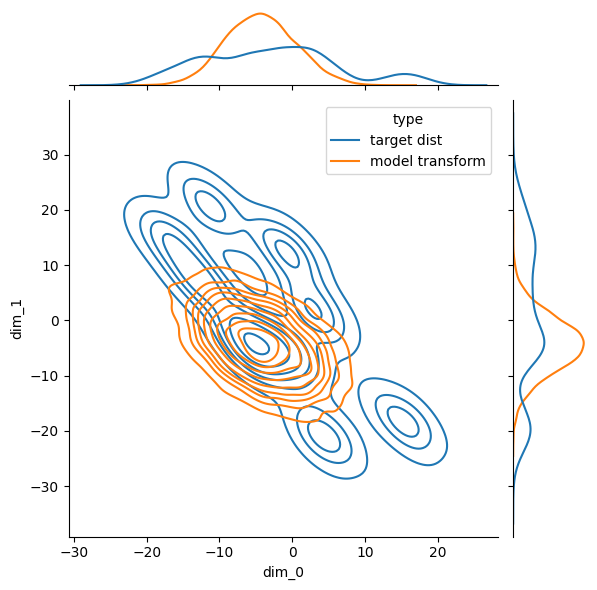

trail: 0 m step: 0 kl_test: 6.761417388916016


 25%|██▌       | 1000/4000 [13:58<46:29,  1.08it/s]

trail: 0 m step: 1 Loss: 4.000556945800781  L_n: 2.6791954040527344  kld: 0.6606807708740234 KLD1: 2.6706695556640625 KLD2: 31.53887367248535


 50%|█████     | 2000/4000 [27:57<31:02,  1.07it/s]

trail: 0 m step: 1 Loss: 3.9735946655273438  L_n: 2.62799072265625  kld: 0.6728019714355469 KLD1: 2.5868074893951416 KLD2: 31.619396209716797


 75%|███████▌  | 3000/4000 [41:56<15:33,  1.07it/s]

trail: 0 m step: 1 Loss: 3.951539993286133  L_n: 2.633859634399414  kld: 0.6588401794433594 KLD1: 2.6177773475646973 KLD2: 31.489171981811523


100%|██████████| 4000/4000 [55:56<00:00,  1.19it/s]

trail: 0 m step: 1 Loss: 3.9244518280029297  L_n: 2.623788833618164  kld: 0.6503314971923828 KLD1: 2.6254842281341553 KLD2: 32.05201721191406



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


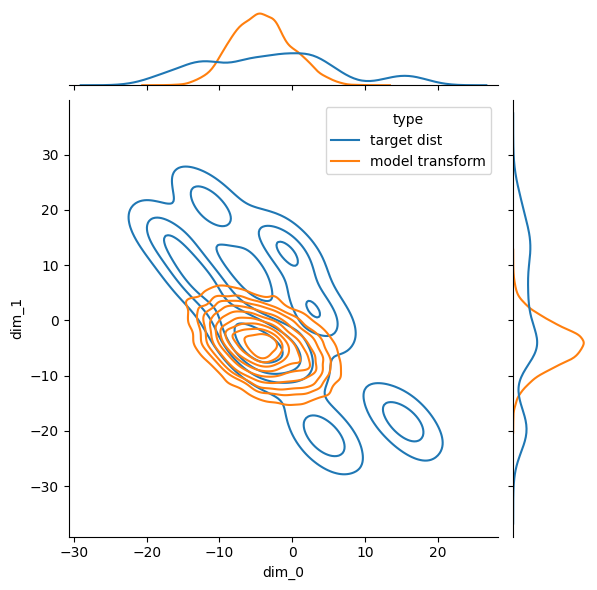

trail: 0 m step: 1 kl_test: 2.5849971771240234


 25%|██▌       | 1000/4000 [14:00<46:41,  1.07it/s]

trail: 0 m step: 2 Loss: 2.050352096557617  L_n: 1.7200374603271484  kld: 0.16515731811523438 KLD1: 1.715867519378662 KLD2: 40.53063201904297


 50%|█████     | 2000/4000 [28:02<31:06,  1.07it/s]

trail: 0 m step: 2 Loss: 2.0406227111816406  L_n: 1.7142181396484375  kld: 0.16320228576660156 KLD1: 1.6879489421844482 KLD2: 39.68242645263672


 75%|███████▌  | 3000/4000 [42:03<15:35,  1.07it/s]

trail: 0 m step: 2 Loss: 2.0372791290283203  L_n: 1.7168102264404297  kld: 0.1602344512939453 KLD1: 1.7099609375 KLD2: 40.014156341552734


100%|██████████| 4000/4000 [56:05<00:00,  1.19it/s]

trail: 0 m step: 2 Loss: 2.0244998931884766  L_n: 1.7201366424560547  kld: 0.15218162536621094 KLD1: 1.7128355503082275 KLD2: 41.08017349243164



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


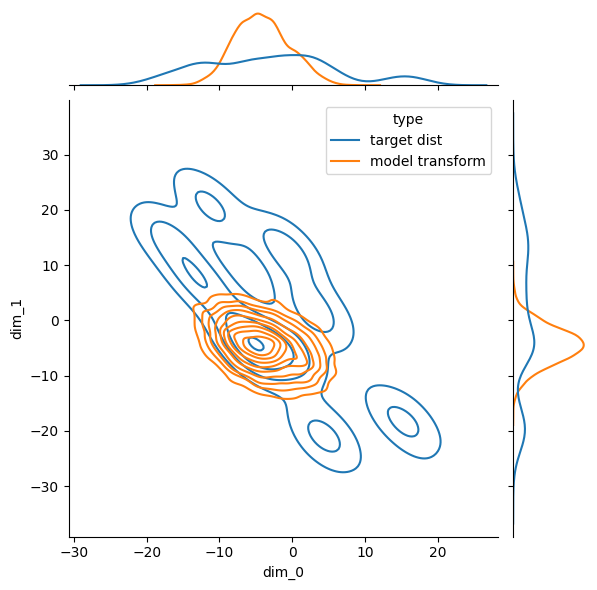

trail: 0 m step: 2 kl_test: 1.6897087097167969


 25%|██▌       | 1000/4000 [14:02<46:45,  1.07it/s]

trail: 0 m step: 3 Loss: 1.5804443359375  L_n: 1.4378700256347656  kld: 0.07128715515136719 KLD1: 1.4373308420181274 KLD2: 45.237648010253906


 50%|█████     | 2000/4000 [28:05<31:09,  1.07it/s]

trail: 0 m step: 3 Loss: 1.5404109954833984  L_n: 1.4286251068115234  kld: 0.0558929443359375 KLD1: 1.4225136041641235 KLD2: 48.30482864379883


 75%|███████▌  | 3000/4000 [42:06<15:36,  1.07it/s]

trail: 0 m step: 3 Loss: 1.54437255859375  L_n: 1.4323387145996094  kld: 0.05601692199707031 KLD1: 1.430890679359436 KLD2: 47.46345520019531


100%|██████████| 4000/4000 [56:08<00:00,  1.19it/s]

trail: 0 m step: 3 Loss: 1.5403690338134766  L_n: 1.430196762084961  kld: 0.05508613586425781 KLD1: 1.4212452173233032 KLD2: 48.32893753051758



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


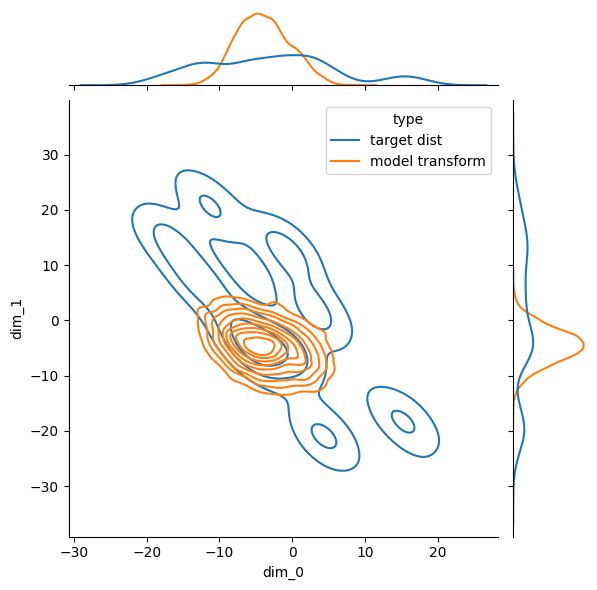

trail: 0 m step: 3 kl_test: 1.410980224609375


 25%|██▌       | 1000/4000 [14:01<46:34,  1.07it/s]

trail: 0 m step: 4 Loss: 1.584991455078125  L_n: 1.3772506713867188  kld: 0.10387039184570312 KLD1: 1.370980143547058 KLD2: 55.05046081542969


 50%|█████     | 2000/4000 [28:00<31:01,  1.07it/s]

trail: 0 m step: 4 Loss: 1.3699836730957031  L_n: 1.3156318664550781  kld: 0.0271759033203125 KLD1: 1.3017523288726807 KLD2: 51.30276870727539


 75%|███████▌  | 3000/4000 [41:59<15:33,  1.07it/s]

trail: 0 m step: 4 Loss: 1.3628616333007812  L_n: 1.3117408752441406  kld: 0.025560379028320312 KLD1: 1.3205219507217407 KLD2: 51.27854537963867


100%|██████████| 4000/4000 [55:58<00:00,  1.19it/s]

trail: 0 m step: 4 Loss: 1.379415512084961  L_n: 1.3226871490478516  kld: 0.028364181518554688 KLD1: 1.3174185752868652 KLD2: 53.62831115722656



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


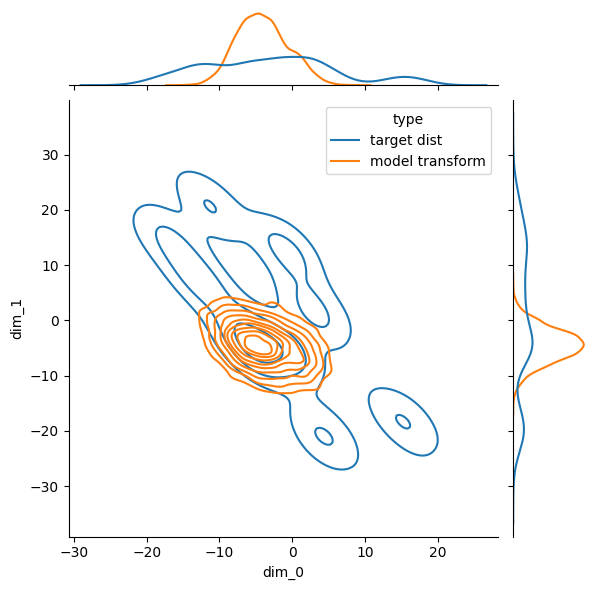

trail: 0 m step: 4 kl_test: 1.3106327056884766


 25%|██▌       | 1000/4000 [13:56<46:20,  1.08it/s]

trail: 0 m step: 5 Loss: 1.307332992553711  L_n: 1.268545150756836  kld: 0.0193939208984375 KLD1: 1.2697011232376099 KLD2: 55.365604400634766


 50%|█████     | 2000/4000 [27:53<31:01,  1.07it/s]

trail: 0 m step: 5 Loss: 1.3081798553466797  L_n: 1.266214370727539  kld: 0.020982742309570312 KLD1: 1.2625845670700073 KLD2: 54.86674880981445


 75%|███████▌  | 3000/4000 [41:51<15:31,  1.07it/s]

trail: 0 m step: 5 Loss: 1.2878150939941406  L_n: 1.26788330078125  kld: 0.009965896606445312 KLD1: 1.2753534317016602 KLD2: 54.50432205200195


100%|██████████| 4000/4000 [55:48<00:00,  1.19it/s]

trail: 0 m step: 5 Loss: 1.3003158569335938  L_n: 1.2702522277832031  kld: 0.015031814575195312 KLD1: 1.2705602645874023 KLD2: 55.67124938964844



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


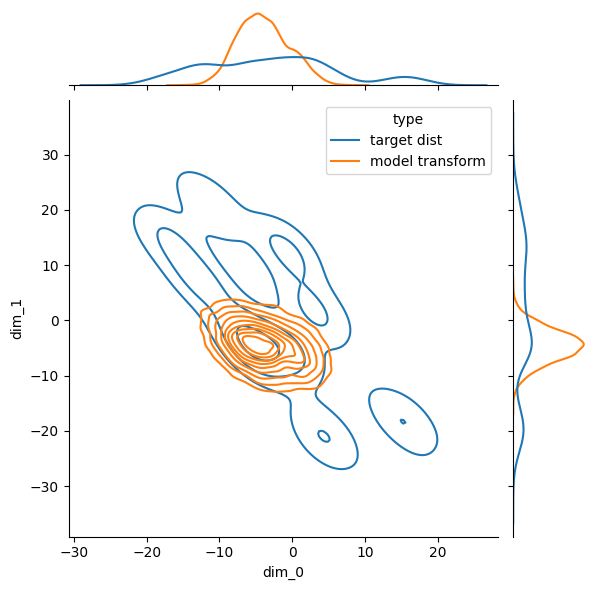

trail: 0 m step: 5 kl_test: 1.2670574188232422


 25%|██▌       | 1000/4000 [13:56<46:32,  1.07it/s]

trail: 0 m step: 6 Loss: 1.3018608093261719  L_n: 1.2618293762207031  kld: 0.020015716552734375 KLD1: 1.2630093097686768 KLD2: 56.65690994262695


 50%|█████     | 2000/4000 [27:53<30:57,  1.08it/s]

trail: 0 m step: 6 Loss: 1.311920166015625  L_n: 1.2608642578125  kld: 0.0255279541015625 KLD1: 1.257262110710144 KLD2: 54.655216217041016


 75%|███████▌  | 3000/4000 [41:50<15:28,  1.08it/s]

trail: 0 m step: 6 Loss: 1.2919254302978516  L_n: 1.253744125366211  kld: 0.019090652465820312 KLD1: 1.254440426826477 KLD2: 53.77467346191406


100%|██████████| 4000/4000 [55:47<00:00,  1.19it/s]

trail: 0 m step: 6 Loss: 1.2674064636230469  L_n: 1.2484474182128906  kld: 0.009479522705078125 KLD1: 1.2517708539962769 KLD2: 53.1750602722168



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


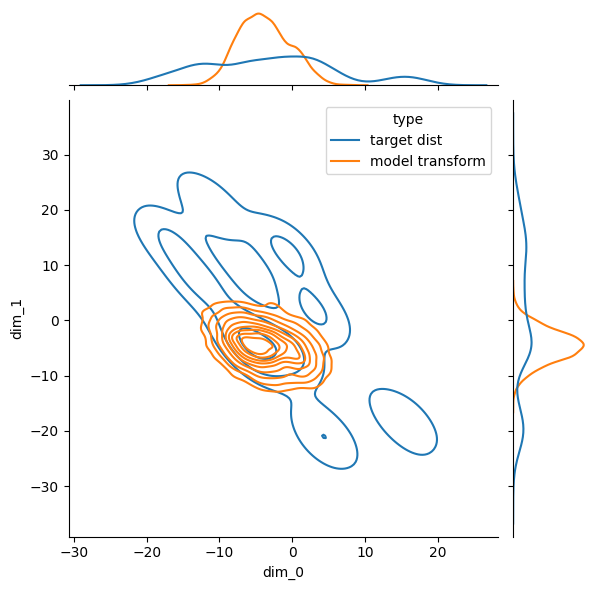

trail: 0 m step: 6 kl_test: 1.2523250579833984


 25%|██▌       | 1000/4000 [13:57<46:34,  1.07it/s]

trail: 0 m step: 7 Loss: 1.263113021850586  L_n: 1.2443599700927734  kld: 0.00937652587890625 KLD1: 1.2404037714004517 KLD2: 52.13119888305664


 50%|█████     | 2000/4000 [27:54<30:58,  1.08it/s]

trail: 0 m step: 7 Loss: 1.2657032012939453  L_n: 1.251871109008789  kld: 0.006916046142578125 KLD1: 1.2432111501693726 KLD2: 52.810150146484375


 75%|███████▌  | 3000/4000 [41:50<15:29,  1.08it/s]

trail: 0 m step: 7 Loss: 1.2696418762207031  L_n: 1.2522430419921875  kld: 0.008699417114257812 KLD1: 1.247336506843567 KLD2: 52.910499572753906


100%|██████████| 4000/4000 [55:47<00:00,  1.19it/s]

trail: 0 m step: 7 Loss: 1.2727546691894531  L_n: 1.2540245056152344  kld: 0.009365081787109375 KLD1: 1.2546337842941284 KLD2: 52.93487548828125



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


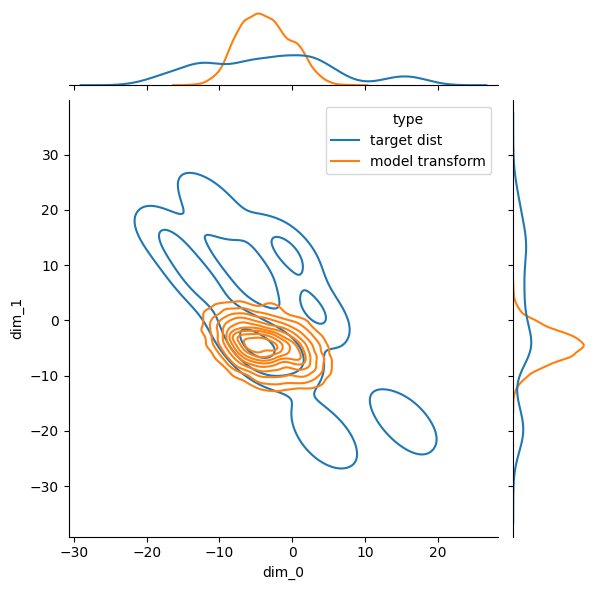

trail: 0 m step: 7 kl_test: 1.254669189453125


 25%|██▌       | 1000/4000 [13:56<46:28,  1.08it/s]

trail: 0 m step: 8 Loss: 1.4291725158691406  L_n: 1.2572822570800781  kld: 0.08594512939453125 KLD1: 1.257928729057312 KLD2: 54.60261154174805


 50%|█████     | 2000/4000 [27:53<30:59,  1.08it/s]

trail: 0 m step: 8 Loss: 1.269073486328125  L_n: 1.25689697265625  kld: 0.0060882568359375 KLD1: 1.2466915845870972 KLD2: 52.25403594970703


 75%|███████▌  | 3000/4000 [41:50<15:30,  1.07it/s]

trail: 0 m step: 8 Loss: 1.2523517608642578  L_n: 1.2395877838134766  kld: 0.006381988525390625 KLD1: 1.2352126836776733 KLD2: 53.241085052490234


100%|██████████| 4000/4000 [55:47<00:00,  1.20it/s]

trail: 0 m step: 8 Loss: 1.2528038024902344  L_n: 1.2367439270019531  kld: 0.008029937744140625 KLD1: 1.237192988395691 KLD2: 54.9238166809082



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


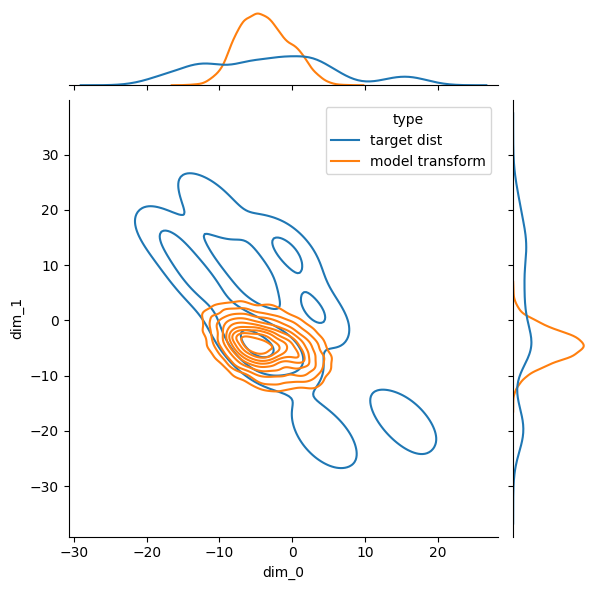

trail: 0 m step: 8 kl_test: 1.2414817810058594


 25%|██▌       | 1000/4000 [13:57<46:32,  1.07it/s]

trail: 0 m step: 9 Loss: 1.268890380859375  L_n: 1.2534294128417969  kld: 0.0077304840087890625 KLD1: 1.249739170074463 KLD2: 57.001930236816406


 50%|█████     | 2000/4000 [27:54<30:59,  1.08it/s]

trail: 0 m step: 9 Loss: 1.282470703125  L_n: 1.2331581115722656  kld: 0.024656295776367188 KLD1: 1.2343398332595825 KLD2: 56.89622497558594


 75%|███████▌  | 3000/4000 [41:51<15:29,  1.08it/s]

trail: 0 m step: 9 Loss: 1.2495403289794922  L_n: 1.2366657257080078  kld: 0.0064373016357421875 KLD1: 1.2364652156829834 KLD2: 54.82324981689453


100%|██████████| 4000/4000 [55:48<00:00,  1.19it/s]

trail: 0 m step: 9 Loss: 1.245676040649414  L_n: 1.2307415008544922  kld: 0.0074672698974609375 KLD1: 1.2320802211761475 KLD2: 57.31509780883789



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


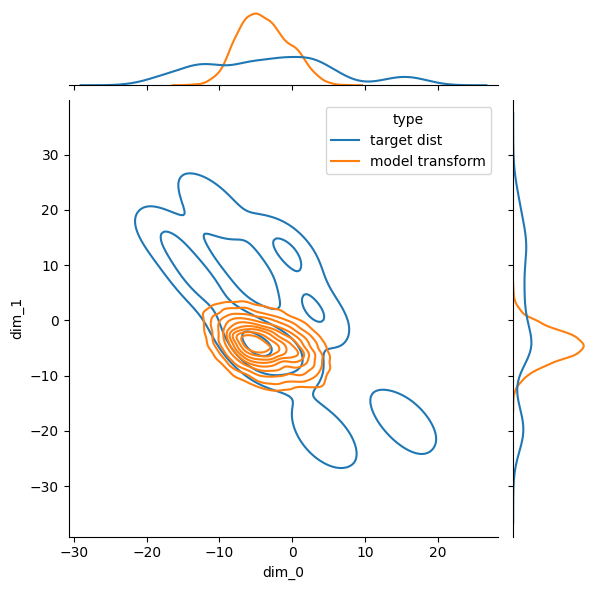

trail: 0 m step: 9 kl_test: 1.232381820678711


 25%|██▌       | 1000/4000 [13:56<46:20,  1.08it/s]

trail: 0 m step: 10 Loss: 1.2774066925048828  L_n: 1.2409687042236328  kld: 0.018218994140625 KLD1: 1.2413297891616821 KLD2: 55.27274703979492


 50%|█████     | 2000/4000 [27:52<30:58,  1.08it/s]

trail: 0 m step: 10 Loss: 1.3028335571289062  L_n: 1.2566757202148438  kld: 0.02307891845703125 KLD1: 1.2477309703826904 KLD2: 55.568946838378906


 75%|███████▌  | 3000/4000 [41:48<15:28,  1.08it/s]

trail: 0 m step: 10 Loss: 1.2494316101074219  L_n: 1.2280502319335938  kld: 0.010690689086914062 KLD1: 1.2350282669067383 KLD2: 55.831260681152344


100%|██████████| 4000/4000 [55:44<00:00,  1.20it/s]

trail: 0 m step: 10 Loss: 1.2399673461914062  L_n: 1.2276420593261719  kld: 0.0061626434326171875 KLD1: 1.2281813621520996 KLD2: 58.45018768310547



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


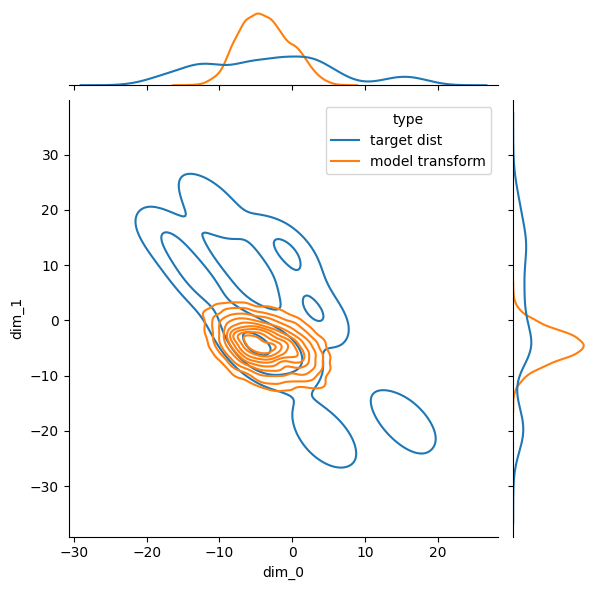

trail: 0 m step: 10 kl_test: 1.224985122680664


 25%|██▌       | 1000/4000 [13:56<46:22,  1.08it/s]

trail: 0 m step: 11 Loss: 1.2751026153564453  L_n: 1.2373790740966797  kld: 0.018861770629882812 KLD1: 1.2376669645309448 KLD2: 59.49156188964844


 50%|█████     | 2000/4000 [27:52<30:56,  1.08it/s]

trail: 0 m step: 11 Loss: 1.2396926879882812  L_n: 1.2259368896484375  kld: 0.006877899169921875 KLD1: 1.2236744165420532 KLD2: 57.64276123046875


 75%|███████▌  | 3000/4000 [41:48<15:27,  1.08it/s]

trail: 0 m step: 11 Loss: 1.2368793487548828  L_n: 1.2259235382080078  kld: 0.0054779052734375 KLD1: 1.2266806364059448 KLD2: 56.71824264526367


100%|██████████| 4000/4000 [55:44<00:00,  1.20it/s]

trail: 0 m step: 11 Loss: 1.233419418334961  L_n: 1.2252864837646484  kld: 0.00406646728515625 KLD1: 1.2258179187774658 KLD2: 57.28803634643555



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


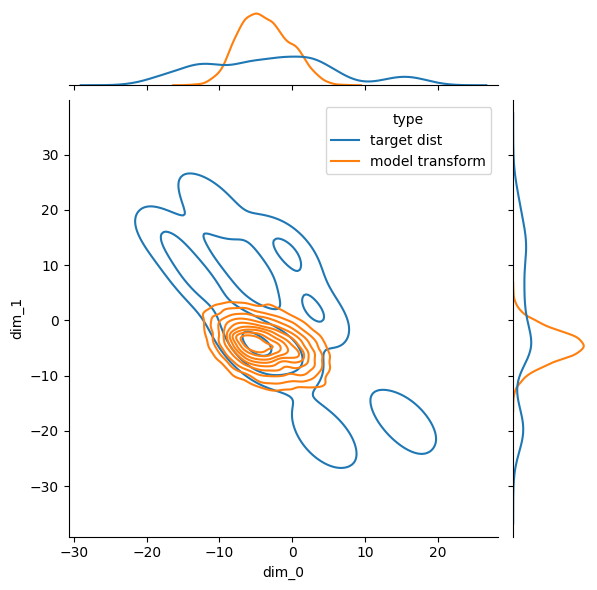

trail: 0 m step: 11 kl_test: 1.2326278686523438


 25%|██▌       | 1000/4000 [13:56<46:27,  1.08it/s]

trail: 0 m step: 12 Loss: 1.2429256439208984  L_n: 1.2308788299560547  kld: 0.006023406982421875 KLD1: 1.2254542112350464 KLD2: 57.9499626159668


 50%|█████     | 2000/4000 [27:53<30:55,  1.08it/s]

trail: 0 m step: 12 Loss: 1.2439498901367188  L_n: 1.2266159057617188  kld: 0.0086669921875 KLD1: 1.2263909578323364 KLD2: 57.098716735839844


 75%|███████▌  | 3000/4000 [41:49<15:30,  1.07it/s]

trail: 0 m step: 12 Loss: 1.2370433807373047  L_n: 1.2227840423583984  kld: 0.007129669189453125 KLD1: 1.2297179698944092 KLD2: 57.17410659790039


100%|██████████| 4000/4000 [55:46<00:00,  1.20it/s]

trail: 0 m step: 12 Loss: 1.2530765533447266  L_n: 1.2308177947998047  kld: 0.011129379272460938 KLD1: 1.232627272605896 KLD2: 59.20375442504883



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


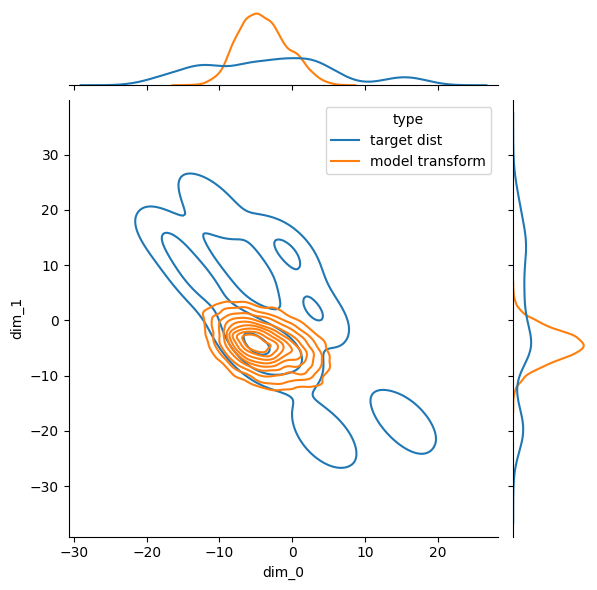

trail: 0 m step: 12 kl_test: 1.2344932556152344


 25%|██▌       | 1000/4000 [13:56<46:28,  1.08it/s]

trail: 0 m step: 13 Loss: 1.3630905151367188  L_n: 1.2484626770019531  kld: 0.05731391906738281 KLD1: 1.2401849031448364 KLD2: 55.81006622314453


 50%|█████     | 2000/4000 [27:53<30:56,  1.08it/s]

trail: 0 m step: 13 Loss: 1.2444782257080078  L_n: 1.2303447723388672  kld: 0.0070667266845703125 KLD1: 1.2340316772460938 KLD2: 59.654754638671875


 75%|███████▌  | 3000/4000 [41:49<15:28,  1.08it/s]

trail: 0 m step: 13 Loss: 1.2383365631103516  L_n: 1.2234210968017578  kld: 0.007457733154296875 KLD1: 1.2325787544250488 KLD2: 57.61176681518555


100%|██████████| 4000/4000 [55:47<00:00,  1.20it/s]

trail: 0 m step: 13 Loss: 1.2409915924072266  L_n: 1.2336292266845703  kld: 0.003681182861328125 KLD1: 1.2351057529449463 KLD2: 61.02906036376953



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


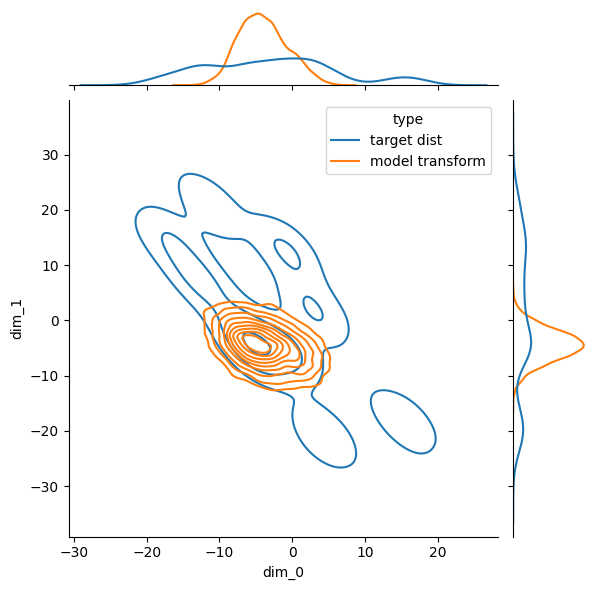

trail: 0 m step: 13 kl_test: 1.2395858764648438


 25%|██▌       | 1000/4000 [13:57<46:29,  1.08it/s]

trail: 0 m step: 14 Loss: 1.2574195861816406  L_n: 1.2352943420410156  kld: 0.0110626220703125 KLD1: 1.2330933809280396 KLD2: 60.32881164550781


 50%|█████     | 2000/4000 [27:54<30:57,  1.08it/s]

trail: 0 m step: 14 Loss: 1.2588768005371094  L_n: 1.2454032897949219  kld: 0.00673675537109375 KLD1: 1.245306372642517 KLD2: 59.401798248291016


 75%|███████▌  | 3000/4000 [41:52<15:28,  1.08it/s]

trail: 0 m step: 14 Loss: 1.244089126586914  L_n: 1.235036849975586  kld: 0.0045261383056640625 KLD1: 1.2439684867858887 KLD2: 59.816009521484375


100%|██████████| 4000/4000 [55:49<00:00,  1.19it/s]

trail: 0 m step: 14 Loss: 1.259735107421875  L_n: 1.2494049072265625  kld: 0.00516510009765625 KLD1: 1.2507481575012207 KLD2: 62.06386184692383



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


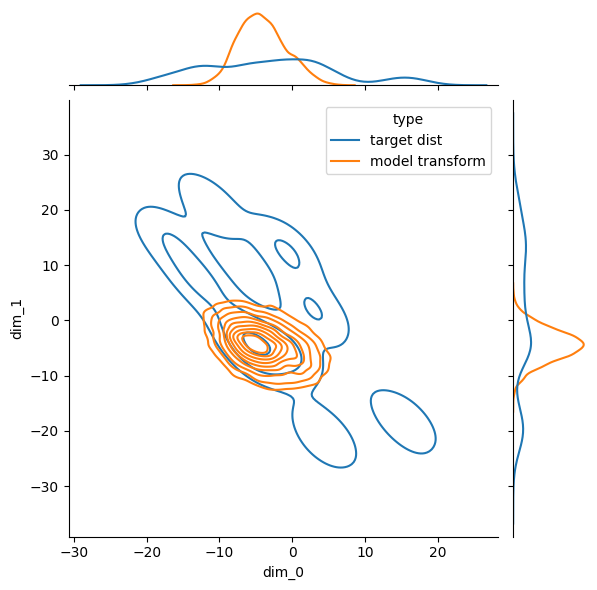

trail: 0 m step: 14 kl_test: 1.2524681091308594


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  lr_decay_factor = math.floor(mirror_itr/30) # decay the lr by 1/4 for every 30 mirror steps
  optimizer_lr_input = optimizer_lr * ((1/4 )** lr_decay_factor)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 1000 == 999:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


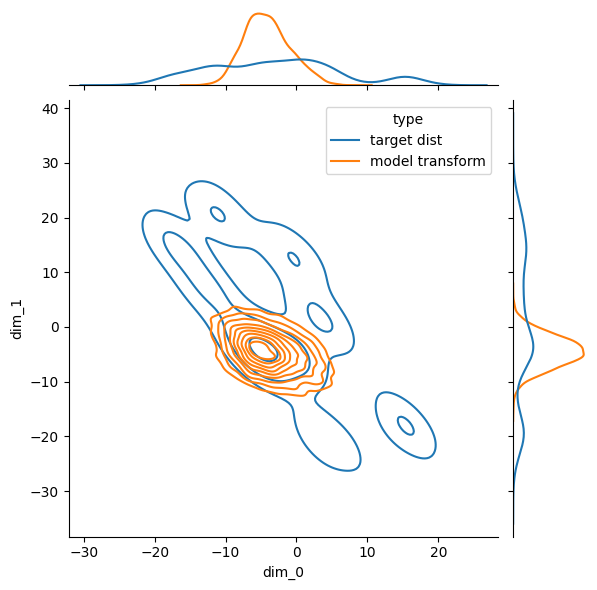

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())